# Learnable Neural Timescales

## Set up

In [42]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


In [43]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Run directory - update this to the latest run
# run_dir = Path(
#     "/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260103_073430"
# )

run_dir = Path(
    "/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260103_085323"
)
print(f"Loading from: {run_dir}")
print(f"Exists: {run_dir.exists()}")

Loading from: /home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260103_085323
Exists: True


## Load Training Metrics


In [44]:
# Load training losses
with open(run_dir / "training_losses.json") as f:
    losses = json.load(f)

# Load position decoding errors
with open(run_dir / "position_decoding_errors.json") as f:
    errors = json.load(f)

epochs = np.array(losses["epochs"])
train_loss = np.array(losses["train_losses_epoch"])
val_loss = np.array(losses["val_losses_epoch"])
decoding_error = np.array(errors["position_errors_epoch"])

print(f"Loaded {len(epochs)} epochs of training data")
print(f"Final train loss: {train_loss[-1]:.4f}")
print(f"Final val loss: {val_loss[-1]:.4f}")
print(f"Final decoding error: {decoding_error[-1]:.4f} m")

Loaded 200 epochs of training data
Final train loss: 5.0771
Final val loss: 5.0772
Final decoding error: 0.0409 m


## Visualize Training Curves


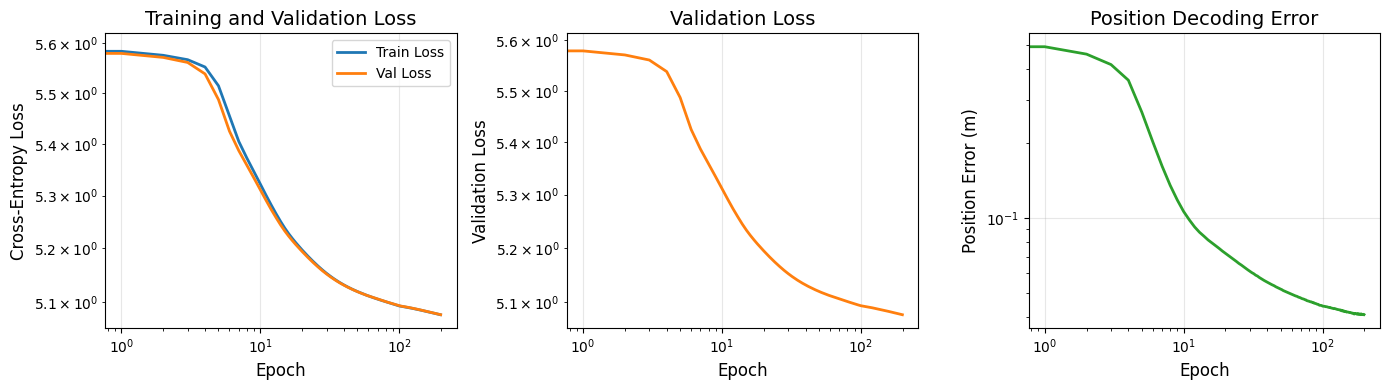

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Training and validation loss
ax = axes[0]
ax.plot(epochs[: len(train_loss)], train_loss, label="Train Loss", linewidth=2)
ax.plot(epochs[: len(val_loss)], val_loss, label="Val Loss", linewidth=2)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Cross-Entropy Loss", fontsize=12)
ax.set_title("Training and Validation Loss", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale("log")
ax.set_xscale("log")

# Val loss only (zoomed)
ax = axes[1]
ax.plot(epochs[: len(val_loss)], val_loss, linewidth=2, color="tab:orange")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Validation Loss", fontsize=12)
ax.set_title("Validation Loss", fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale("log")
ax.set_xscale("log")

# Position decoding error
ax = axes[2]
ax.plot(epochs[: len(decoding_error)], decoding_error, linewidth=2, color="tab:green")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Position Error (m)", fontsize=12)
ax.set_title("Position Decoding Error", fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale("log")
ax.set_xscale("log")
plt.tight_layout()
plt.show()

## Load Trained Model and Extract Learned Timescales


In [46]:
from timescales.rnns.multitimescale_rnn import (
    MultiTimescaleRNN,
    MultiTimescaleRNNLightning,
)
import yaml

# Load config from saved file
config_path = run_dir / "config_seed0.yaml"
with open(config_path) as f:
    config = yaml.safe_load(f)

print(f"Loaded config from: {config_path}")

# Find the best checkpoint
checkpoint_dir = run_dir / "checkpoints"
best_checkpoints = list(checkpoint_dir.glob("best-model-*.ckpt"))
if best_checkpoints:
    checkpoint_path = best_checkpoints[0]
else:
    checkpoint_path = checkpoint_dir / "last.ckpt"

print(f"Loading checkpoint: {checkpoint_path}")

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Create model with learnable timescales
model = MultiTimescaleRNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["num_place_cells"],
    dt=config["dt"],
    timescales_config=None,  # Not needed for learnable
    activation=getattr(nn, config["activation"]),
    learn_timescales=config.get("learn_timescales", True),
)

# Load state dict
lightning_module = MultiTimescaleRNNLightning(
    model=model,
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"],
    step_size=config["step_size"],
    gamma=config["gamma"],
)
lightning_module.load_state_dict(checkpoint["state_dict"])
model = lightning_module.model
model.eval()

print("Model loaded successfully!")
print(f"Timescale statistics: {model.get_timescale_stats()}")

Loaded config from: /home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260103_085323/config_seed0.yaml
Loading checkpoint: /home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260103_085323/checkpoints/best-model-epoch=199-val_loss=5.077.ckpt
Timescales are LEARNABLE (randomly initialized)
Model loaded successfully!
Timescale statistics: {'timescale_min': 0.5462880730628967, 'timescale_max': 0.8315288424491882, 'timescale_mean': 0.6583913564682007, 'timescale_std': 0.05721758306026459, 'alpha_min': 0.11331051588058472, 'alpha_max': 0.1672765016555786, 'alpha_mean': 0.14180085062980652, 'unique_timescales': 512, 'learn_timescales': True}


In [47]:
# Extract learned timescales
learned_timescales = model.rnn_step.current_timescales.detach().cpu().numpy()
learned_alphas = model.rnn_step.current_alphas.detach().cpu().numpy()

print(
    f"Learned timescales: min={learned_timescales.min():.4f}, max={learned_timescales.max():.4f}, mean={learned_timescales.mean():.4f}"
)
print(
    f"Learned alphas: min={learned_alphas.min():.4f}, max={learned_alphas.max():.4f}, mean={learned_alphas.mean():.4f}"
)

Learned timescales: min=0.5463, max=0.8315, mean=0.6584
Learned alphas: min=0.1133, max=0.1673, mean=0.1418


## Behavioral Timescale Distribution

The behavioral timescale is defined as τ_behavior = place_cell_rf / linear_speed.

The config supports two parameterizations:
- **Option A**: Direct speed parameters (linear_speed_mean, linear_speed_std)
- **Option B**: Behavioral timescale parameters (behavioral_timescale_mean, behavioral_timescale_std)

We load from the saved config to determine which was used.


In [48]:
import yaml

# Load config from saved file
config_path = run_dir / "config_seed0.yaml"
with open(config_path) as f:
    config = yaml.safe_load(f)

place_cell_rf = config["place_cell_rf"]

# Check which parameterization was used
if (
    "behavioral_timescale_mean" in config
    and config["behavioral_timescale_mean"] is not None
):
    # Option B: Behavioral timescale parameterization (used directly)
    behavioral_timescale_mean = config["behavioral_timescale_mean"]
    behavioral_timescale_std = config.get("behavioral_timescale_std", 0.0)

    print(f"Using behavioral timescale parameterization:")
    print(
        f"  τ_behavior: mean={behavioral_timescale_mean}s, std={behavioral_timescale_std}s"
    )

    # Sample behavioral timescales directly
    np.random.seed(42)
    n_samples = 10000
    behavioral_timescales = np.abs(
        np.random.normal(behavioral_timescale_mean, behavioral_timescale_std, n_samples)
    )
    behavioral_timescales = np.clip(behavioral_timescales, 0.01, None)
    typical_behavioral_timescale = behavioral_timescale_mean

else:
    # Option A: Direct speed parameterization
    linear_speed_mean = config["linear_speed_mean"]
    linear_speed_std = config.get("linear_speed_std", 0.0)

    print(f"Using speed parameterization:")
    print(f"  speed: mean={linear_speed_mean}m/s, std={linear_speed_std}m/s")

    # Sample speeds and convert to behavioral timescales
    np.random.seed(42)
    n_samples = 10000
    speeds = np.abs(np.random.normal(linear_speed_mean, linear_speed_std, n_samples))
    speeds = np.clip(speeds, 0.01, None)
    behavioral_timescales = place_cell_rf / speeds
    typical_behavioral_timescale = place_cell_rf / linear_speed_mean

print(f"\nTypical behavioral timescale: {typical_behavioral_timescale:.3f} s")
print(
    f"Sampled behavioral timescales: mean={behavioral_timescales.mean():.3f}, median={np.median(behavioral_timescales):.3f}"
)

Using behavioral timescale parameterization:
  τ_behavior: mean=1.0s, std=0.2s

Typical behavioral timescale: 1.000 s
Sampled behavioral timescales: mean=1.000, median=0.999


## Compare Behavioral and Learned Neural Timescale Distributions


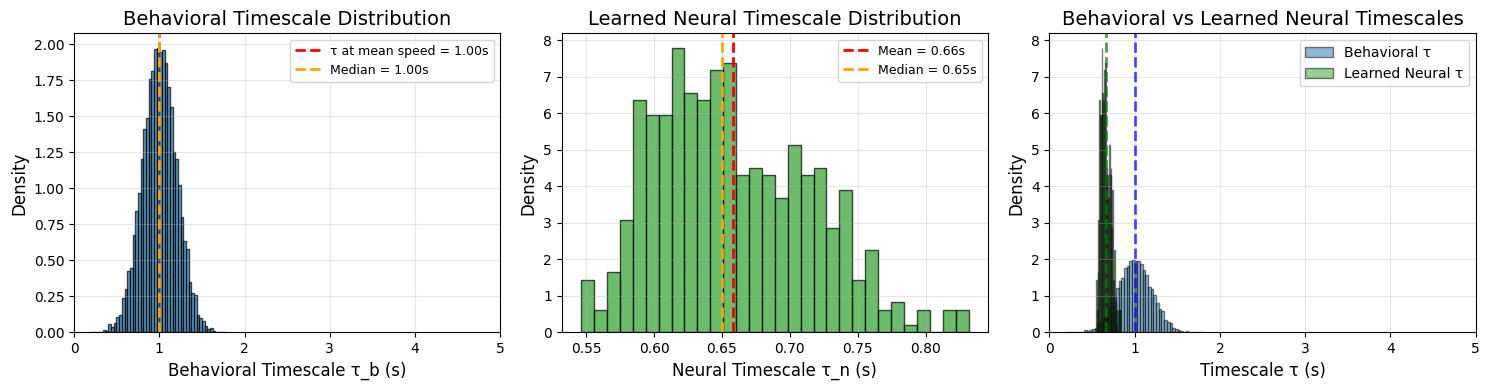

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Behavioral timescale distribution
ax = axes[0]
ax.hist(
    behavioral_timescales,
    bins=50,
    alpha=0.7,
    color="tab:blue",
    edgecolor="black",
    density=True,
)
ax.axvline(
    typical_behavioral_timescale,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"τ at mean speed = {typical_behavioral_timescale:.2f}s",
)
ax.axvline(
    np.median(behavioral_timescales),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median = {np.median(behavioral_timescales):.2f}s",
)
ax.set_xlabel("Behavioral Timescale τ_b (s)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Behavioral Timescale Distribution", fontsize=14)
ax.set_xlim(0, 5)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Learned neural timescale distribution
ax = axes[1]
ax.hist(
    learned_timescales,
    bins=30,
    alpha=0.7,
    color="tab:green",
    edgecolor="black",
    density=True,
)
ax.axvline(
    learned_timescales.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean = {learned_timescales.mean():.2f}s",
)
ax.axvline(
    np.median(learned_timescales),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median = {np.median(learned_timescales):.2f}s",
)
ax.set_xlabel("Neural Timescale τ_n (s)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Learned Neural Timescale Distribution", fontsize=14)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 3. Overlay comparison
ax = axes[2]
ax.hist(
    behavioral_timescales,
    bins=50,
    alpha=0.5,
    color="tab:blue",
    edgecolor="black",
    density=True,
    label="Behavioral τ",
)
ax.hist(
    learned_timescales,
    bins=30,
    alpha=0.5,
    color="tab:green",
    edgecolor="black",
    density=True,
    label="Learned Neural τ",
)
ax.axvline(
    typical_behavioral_timescale, color="blue", linestyle="--", linewidth=2, alpha=0.7
)
ax.axvline(
    learned_timescales.mean(), color="green", linestyle="--", linewidth=2, alpha=0.7
)
ax.set_xlabel("Timescale τ (s)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Behavioral vs Learned Neural Timescales", fontsize=14)
ax.set_xlim(0, 5)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional visualization: Alpha distribution and summary statistics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Learned alpha distribution
ax = axes[0]
ax.hist(learned_alphas, bins=30, alpha=0.7, color="tab:purple", edgecolor="black", density=True)
ax.axvline(learned_alphas.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean α = {learned_alphas.mean():.3f}")
ax.set_xlabel("Update Rate α = 1 - exp(-dt/τ)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Learned Alpha Distribution", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Timescale vs Alpha scatter
ax = axes[1]
ax.scatter(learned_timescales, learned_alphas, alpha=0.5, s=10)
ax.set_xlabel("Timescale τ (s)", fontsize=12)
ax.set_ylabel("Update Rate α", fontsize=12)
ax.set_title("Timescale vs Update Rate", fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nBehavioral Timescale (at mean speed): {typical_behavioral_timescale:.3f} s")
print(f"\nLearned Neural Timescales:")
print(f"  Mean:   {learned_timescales.mean():.4f} s")
print(f"  Median: {np.median(learned_timescales):.4f} s")
print(f"  Std:    {learned_timescales.std():.4f} s")
print(f"  Min:    {learned_timescales.min():.4f} s")
print(f"  Max:    {learned_timescales.max():.4f} s")
print(f"\nRatio (mean neural / behavioral): {learned_timescales.mean() / typical_behavioral_timescale:.3f}")


## Timescale Evolution During Training

Track how the learned timescale distribution changes over the course of training.


In [50]:
# Load timescale history
history_path = run_dir / "timescale_history.json"
if history_path.exists():
    with open(history_path) as f:
        timescale_history = json.load(f)

    # Get epochs that have full timescales saved
    saved_epochs = sorted([int(e) for e in timescale_history["full_timescales"].keys()])
    print(f"Timescale history loaded!")
    print(f"Statistics tracked for {len(timescale_history['epochs'])} epochs")
    print(f"Full timescales saved at epochs: {saved_epochs}")
else:
    print(f"No timescale history found at {history_path}")
    print(
        "Run training with the updated TimescaleVisualizationCallback to generate this file."
    )

Timescale history loaded!
Statistics tracked for 200 epochs
Full timescales saved at epochs: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


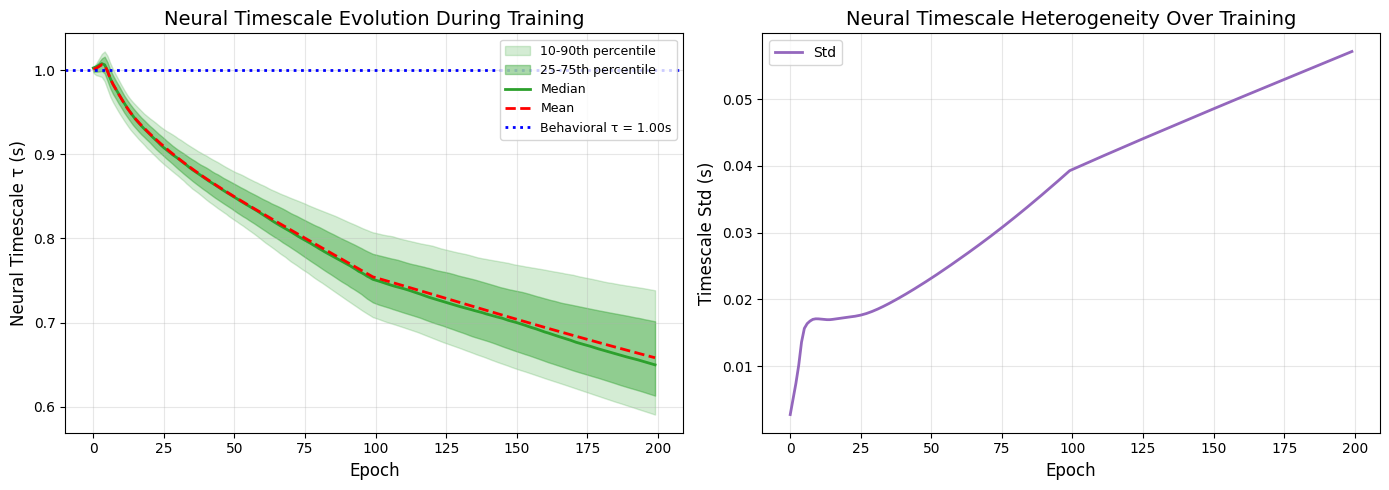

In [51]:
# Plot timescale statistics over training
if history_path.exists():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    hist_epochs = timescale_history["epochs"]

    # Plot 1: Mean and percentiles over time
    ax = axes[0]
    ax.fill_between(
        hist_epochs,
        timescale_history["percentile_10"],
        timescale_history["percentile_90"],
        alpha=0.2,
        color="tab:green",
        label="10-90th percentile",
    )
    ax.fill_between(
        hist_epochs,
        timescale_history["percentile_25"],
        timescale_history["percentile_75"],
        alpha=0.4,
        color="tab:green",
        label="25-75th percentile",
    )
    ax.plot(
        hist_epochs,
        timescale_history["percentile_50"],
        color="tab:green",
        linewidth=2,
        label="Median",
    )
    ax.plot(
        hist_epochs,
        timescale_history["mean"],
        color="red",
        linewidth=2,
        linestyle="--",
        label="Mean",
    )
    ax.axhline(
        typical_behavioral_timescale,
        color="blue",
        linestyle=":",
        linewidth=2,
        label=f"Behavioral τ = {typical_behavioral_timescale:.2f}s",
    )

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Neural Timescale τ (s)", fontsize=12)
    ax.set_title("Neural Timescale Evolution During Training", fontsize=14)
    ax.legend(fontsize=9, loc="upper right")
    ax.grid(True, alpha=0.3)

    # Plot 2: Std over time
    ax = axes[1]
    ax.plot(
        hist_epochs,
        timescale_history["std"],
        color="tab:purple",
        linewidth=2,
        label="Std",
    )
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Timescale Std (s)", fontsize=12)
    ax.set_title("Neural Timescale Heterogeneity Over Training", fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping evolution plot - no history data available.")

### Animation of Timescale Distribution


In [52]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

if history_path.exists() and len(saved_epochs) > 1:
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Determine global x-axis range from all epochs
    all_timescales = []
    for epoch in saved_epochs:
        all_timescales.extend(timescale_history["full_timescales"][str(epoch)])
    x_min, x_max = min(all_timescales) * 0.9, max(all_timescales) * 1.1
    bins = np.linspace(x_min, x_max, 40)

    def animate(frame_idx):
        ax.clear()
        epoch = saved_epochs[frame_idx]
        timescales = np.array(timescale_history["full_timescales"][str(epoch)])

        ax.hist(
            timescales,
            bins=bins,
            alpha=0.7,
            color="tab:green",
            edgecolor="black",
            density=True,
        )
        ax.axvline(
            timescales.mean(),
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean = {timescales.mean():.3f}s",
        )
        ax.axvline(
            typical_behavioral_timescale,
            color="blue",
            linestyle="--",
            linewidth=2,
            label=f"Behavioral τ = {typical_behavioral_timescale:.2f}s",
        )

        ax.set_xlabel("Neural Timescale τ (s)", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        ax.set_title(f"Learned Neural Timescales - Epoch {epoch}", fontsize=14)
        ax.set_xlim(x_min, x_max)
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

    # Create animation
    anim = FuncAnimation(
        fig, animate, frames=len(saved_epochs), interval=500, repeat=True
    )
    plt.close(fig)

    # Display in notebook - must use display() inside if-block
    display(HTML(anim.to_jshtml()))
else:
    print("Animation requires timescale history with multiple saved epochs.")